# Import Libraries

In [1]:
# Here are several helpful packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # some plotting!
import seaborn as sns # so pretty!
from scipy import stats # I might use this
from sklearn.ensemble import RandomForestClassifier # checking if this is available
# from sklearn import cross_validation
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



# Train & Test data

In [2]:
# import the training data set and make sure it's in correctly...
train = pd.read_csv('../input/train.csv')
train_original = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

1. **Feature Types**:
   - Our dataset contains three types of features: **integer**, **float**, and **categorical** (object) features.
   - Additionally, some features appear to be relevant only for a subset of the 1,460 samples.

2. **Handling Missing Data**:
   - We will exclude features with missing data for now.

3. **Pre-processing Categorical Features**:
   - We propose creating a function to convert categorical features into integer representations.
   - The conversion will assign integers based on the frequency of each category: the most common category becomes 0, the next most common becomes 1, and so forth.
   - This transformation could prove useful for subsequent analysis.

In [3]:
# define a function to convert an object (categorical) feature into an int feature
# 0 = most common category, highest int = least common.
def getObjectFeature(df, col, datalength=1460):
    if df[col].dtype!='object': # if it's not categorical..
        print('feature',col,'is not an object feature.')
        return df
    elif len([i for i in df[col].T.notnull() if i == True])!=datalength: # if there's missing data..
        print('feature',col,'is missing data.')
        return df
    else:
        df1 = df
        counts = df1[col].value_counts() # get the counts for each label for the feature
        df1[col] = [counts.index.tolist().index(i) for i in df1[col]] # do the conversion
        return df1 # make the new (integer) column from the conversion
# and test the function...
fcntest = getObjectFeature(train,'LotShape')
fcntest.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


1. **Target Variable Analysis**:
   - Our focus is on the ***Sale Price*** data, which serves as the target variable.
   - We aim to assess whether the distribution of Sale Price follows a ***normal distribution***.

2. **Normality Check**:
   - We will examine the distribution of Sale Price and determine if it adheres to the characteristics of a normal distribution.
   - If deviations from normality are observed, we will explore corrective measures.

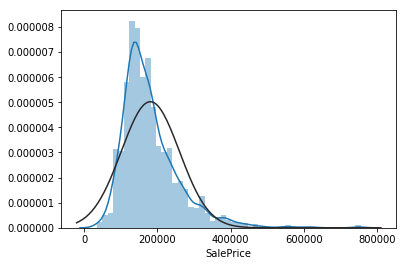

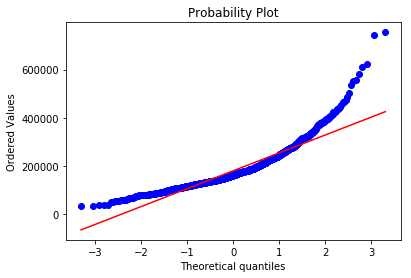

In [4]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

 **Distribution Assessment :**
   - The distribution of the Sale Price data exhibits **right-skewness** and a **peak-y** shape.
   - Our next step is to apply a **logarithmic transformation** to the data and observe the impact.


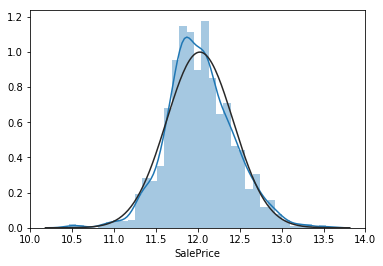

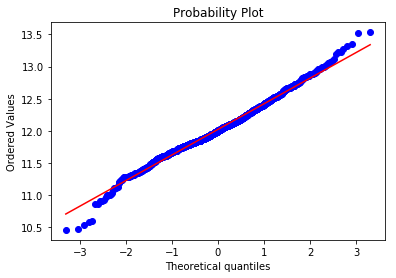

In [5]:
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

The revised output appears to be more normally distributed, which is expected to enhance the performance of our regression models. It is essential to bear in mind that when submitting results, we must apply an inverse transformation to the output data using exponentiation.

# Random Tree Regressor

To begin our analysis, we will train a simple model using only the features outlined in the "benchmark" solution. These features include:

1. **Year and Month of Sale**
2. **Lot Square Footage**
3. **Number of Bedrooms**

Our initial approach involves implementing a straightforward decision tree regression. To evaluate performance and mitigate overfitting, we will employ k-fold validation. Let's preprocess the data to ensure its suitability for modeling.


In [6]:
from sklearn.tree import DecisionTreeRegressor as dtr
# define the training data X...
X = train[['MoSold','YrSold','LotArea','BedroomAbvGr']]
Y = train[['SalePrice']]
# and the data 
X_test = test[['MoSold','YrSold','LotArea','BedroomAbvGr']]
print(X.head())
print(Y.head())

   MoSold  YrSold  LotArea  BedroomAbvGr
0       2    2008     8450             3
1       5    2007     9600             3
2       9    2008    11250             3
3       2    2006     9550             3
4      12    2008    14260             4
   SalePrice
0  12.247694
1  12.109011
2  12.317167
3  11.849398
4  12.429216


... and now we can use cross validation to see how well a proposed regression model performs. 

## Explained Variance as a Performance Metric
For now, we use explained variance, $EV$, as a metric to evaluate the performance of a model:

$EV = 1 - \frac{Var(y-\bar{y})}{Var(y)}$

where $y$ is the true price, $\bar{y}$ is the estimated price from the model, and $Var(\cdot)$ is the variance. The $\bar{y}$ estimates come from predictions made on the data witheld from training in each round of cross-validation. See: 
http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score 

Let's apply this metric...

In [7]:
# let's set up some cross-validation analysis to evaluate our model and later models...
from sklearn.model_selection import cross_val_score
# try fitting a decision tree regression model...
DTR_1 = dtr(max_depth=None) # declare the regression model form. Let the depth be default.
# DTR_1.fit(X,Y) # fit the training data
scores_dtr = cross_val_score(DTR_1, X, Y, cv=10,scoring='explained_variance') # 10-fold cross validation
print('scores for k=10 fold validation:',scores_dtr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

scores for k=10 fold validation: [-0.36738494 -0.34548191 -0.28471074 -0.43725959 -0.17166163 -0.56317275
 -0.59803353 -0.63440301 -1.16130382 -0.27550748]
Est. explained variance: -0.48 (+/- 0.54)


## The Random Tree Regressor: A Terrible Model
Wow, that's.... super bad. For explained variance, the best possible result is 1, which would correspond to $Var(y-y_{est})=0$. Values below 1 indicate error in the regression. Negative values imply $Var(y-\bar{y}) > Var(y)$, which is frankly embarrasing.

# Seeing the Random Forest for the Trees

So, using one tree is a bad idea... but what if we consider an ensemble of trees? Let's use a random forest regressor instead. We will consider forests with varying numbers of trees (estimators), each of which provides a weak regression solution that can be averaged to get the overall regression output. See: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [8]:
from sklearn.ensemble import RandomForestRegressor as rfr
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in Y['SalePrice']] # quick pre-processing of the target
np.random.seed(11111)
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None)
    scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

estimators: 2
Est. explained variance: -0.15 (+/- 0.26)

estimators: 5
Est. explained variance: 0.00 (+/- 0.25)

estimators: 10
Est. explained variance: 0.10 (+/- 0.19)

estimators: 15
Est. explained variance: 0.13 (+/- 0.20)

estimators: 20
Est. explained variance: 0.15 (+/- 0.16)

estimators: 25
Est. explained variance: 0.14 (+/- 0.18)

estimators: 30
Est. explained variance: 0.13 (+/- 0.21)

estimators: 35
Est. explained variance: 0.16 (+/- 0.17)

estimators: 40
Est. explained variance: 0.15 (+/- 0.16)

estimators: 45
Est. explained variance: 0.16 (+/- 0.16)

estimators: 50
Est. explained variance: 0.15 (+/- 0.18)

estimators: 55
Est. explained variance: 0.16 (+/- 0.18)

estimators: 60
Est. explained variance: 0.16 (+/- 0.19)

estimators: 65
Est. explained variance: 0.15 (+/- 0.18)

estimators: 70
Est. explained variance: 0.16 (+/- 0.18)

estimators: 75
Est. explained variance: 0.16 (+/- 0.17)

estimators: 80
Est. explained variance: 0.16 (+/- 0.18)



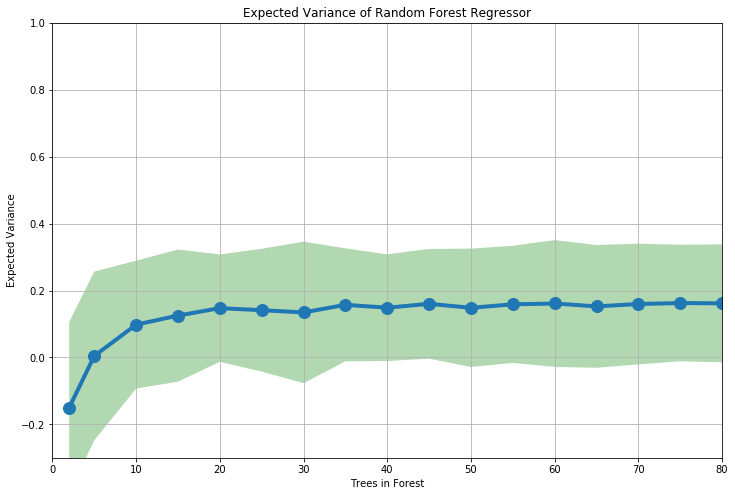

In [9]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)
ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

## Random Forests: A Modest Progress

Despite the persistently suboptimal outcomes, there is a glimmer of hope. The estimated means for explained variance now exhibit a positive trend, albeit modest. This incremental improvement suggests that our model is inching toward better performance.

However, the underwhelming results from densely populated forests underscore the need for additional features. It is evident that our current feature set lacks the necessary discriminatory power. To address this, we propose augmenting the feature space by introducing carefully selected variables.

### Next Steps

1. **Feature Expansion**: Identify relevant features that can enhance predictive accuracy.
2. **Model Tuning**: Fine-tune hyperparameters to strike a balance between bias and variance.
3. **Validation**: Rigorously validate the updated model using cross-validation techniques.

By iteratively refining our approach, we aim to transform these incremental gains into substantial advancements.


In [10]:
# list all the features we want. This is still arbitrary...
included_features = ['MoSold','YrSold','LotArea','BedroomAbvGr', # original data
                    'FullBath','HalfBath','TotRmsAbvGrd', # bathrooms and total rooms
                    'YearBuilt','YearRemodAdd', # age of the house
                    'LotShape','Utilities'] # some categoricals 
# define the training data X...
X = train[included_features]
Y = train[['SalePrice']]
# and the data...
X_test = test[included_features]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
X.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,MoSold,YrSold,LotArea,BedroomAbvGr,FullBath,HalfBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,LotShape,Utilities
0,2,2008,8450,3,2,1,8,2003,2003,0,0
1,5,2007,9600,3,2,0,6,1976,1976,0,0
2,9,2008,11250,3,2,1,6,2001,2002,1,0
3,2,2006,9550,3,1,0,7,1915,1970,1,0
4,12,2008,14260,4,2,1,9,2000,2000,1,0


In [11]:
# define the number of estimators to consider
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in Y['SalePrice']]
np.random.seed(11111)
# for each number of estimators, fit the model and find the results for 8-fold cross validation
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None)
    scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print("")
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

estimators: 2
Est. explained variance: 0.58 (+/- 0.16)

estimators: 5
Est. explained variance: 0.67 (+/- 0.09)

estimators: 10
Est. explained variance: 0.69 (+/- 0.10)

estimators: 15
Est. explained variance: 0.69 (+/- 0.09)

estimators: 20
Est. explained variance: 0.70 (+/- 0.08)

estimators: 25
Est. explained variance: 0.70 (+/- 0.10)

estimators: 30
Est. explained variance: 0.71 (+/- 0.08)

estimators: 35
Est. explained variance: 0.71 (+/- 0.09)

estimators: 40
Est. explained variance: 0.71 (+/- 0.10)

estimators: 45
Est. explained variance: 0.72 (+/- 0.09)

estimators: 50
Est. explained variance: 0.71 (+/- 0.09)

estimators: 55
Est. explained variance: 0.71 (+/- 0.09)

estimators: 60
Est. explained variance: 0.72 (+/- 0.10)

estimators: 65
Est. explained variance: 0.72 (+/- 0.08)

estimators: 70
Est. explained variance: 0.71 (+/- 0.09)

estimators: 75
Est. explained variance: 0.72 (+/- 0.09)

estimators: 80
Est. explained variance: 0.71 (+/- 0.09)



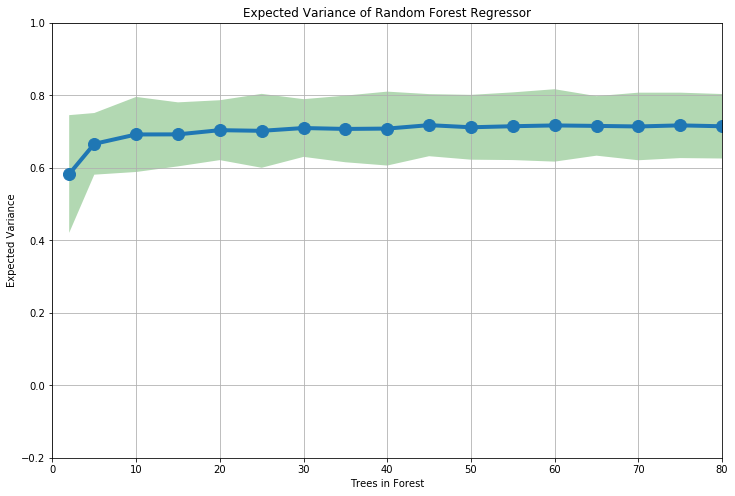

In [12]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)
ax.set_ylim([-.2,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

## Enhancing Random Forest Regressors Through Scientific Feature Analysis

In our pursuit of improving random forest regression models, we shall continue to employ this robust technique. However, our approach will now be grounded in scientific principles as we meticulously select features for training the forests. To achieve this, we will conduct a thorough feature analysis.

**Step 1: Feature Collection and Transformation**

Our initial task involves gathering all available features. Additionally, we will address any categorical features by applying appropriate transformations.

In [13]:
import sklearn.feature_selection as fs # feature selection library in scikit-learn
train = pd.read_csv('../input/train.csv') # get the training data again just in case
train['SalePrice'] = np.log(train['SalePrice'])
# first, let's include every feature that has data for all 1460 houses in the data set...
included_features = [col for col in list(train)
                    if len([i for i in train[col].T.notnull() if i == True])==1460
                    and col!='SalePrice' and col!='id']
# define the training data X...
X = train[included_features] # the feature data
Y = train[['SalePrice']] # the target
yt = [i for i in Y['SalePrice']] # the target list 
# and the data...
X_test = test[included_features]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
X.head()
# Y.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,0,8450,0,0,0,0,0,0,...,61,0,0,0,0,0,2,2008,0,0
1,2,20,0,9600,0,0,0,0,3,0,...,0,0,0,0,0,0,5,2007,0,0
2,3,60,0,11250,0,1,0,0,0,0,...,42,0,0,0,0,0,9,2008,0,0
3,4,70,0,9550,0,1,0,0,1,0,...,35,272,0,0,0,0,2,2006,0,2
4,5,60,0,14260,0,1,0,0,3,0,...,84,0,0,0,0,0,12,2008,0,0


**Step 2: Enhancing Feature Selection with Mutual Information Regression**

In our pursuit of optimizing feature selection for regression models, we will employ the **mutual information regression** metric. This powerful tool quantifies the dependence between two random variables: each feature within our dataset and the target variable (in this case, the sales price regression target). By assessing this dependence, we gain insights into the relevance of individual features.

However, it's essential to note that mutual information regression does not account for feature value combinations. For instance, it does not directly consider interactions between the sales price and other features, such as the year of sale combined with overall quality. Despite this limitation, mutual information regression remains a valuable technique for ranking and selecting features.

See: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

In [14]:
mir_result = fs.mutual_info_regression(X, yt) # mutual information regression feature ordering
feature_scores = []
for i in np.arange(len(included_features)):
    feature_scores.append([included_features[i],mir_result[i]])
sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


[['OverallQual' '0.513638172174']
 ['GrLivArea' '0.370362761174']
 ['GarageCars' '0.363067861809']
 ['KitchenQual' '0.333816397398']
 ['ExterQual' '0.32876409725']
 ['GarageArea' '0.288564418897']
 ['TotalBsmtSF' '0.265984510681']
 ['FullBath' '0.262270787714']
 ['1stFlrSF' '0.261994730628']
 ['YearBuilt' '0.259608433369']
 ['YearRemodAdd' '0.19600822777']
 ['Foundation' '0.195626580985']
 ['TotRmsAbvGrd' '0.191502053325']
 ['Fireplaces' '0.170319977323']
 ['HeatingQC' '0.169955921911']
 ['BsmtFinSF1' '0.131088111214']
 ['MSZoning' '0.121486166688']
 ['OverallCond' '0.113493734868']
 ['2ndFlrSF' '0.108673750888']
 ['LotShape' '0.0979153207264']
 ['HalfBath' '0.0876808362195']
 ['LotArea' '0.0875187368582']
 ['SaleType' '0.0786177211471']
 ['SaleCondition' '0.0746072717317']
 ['BedroomAbvGr' '0.0676400172657']
 ['CentralAir' '0.0639223060812']
 ['MSSubClass' '0.0621486597']
 ['OpenPorchSF' '0.0579227282531']
 ['HouseStyle' '0.0506487336246']
 ['BsmtUnfSF' '0.0504051652468']
 ['PavedDriv

**Step 3: Key Factors Influencing Homebuyers' Preferences**

Our analysis of the mutual information regression (MIR) results reveals critical factors that significantly impact the sales price of residential properties. These factors, when considered in the context of homebuyers' preferences, provide valuable insights for real estate decision-making.

1. **Overall Quality**: A home's overall quality emerges as a pivotal determinant of its market valail.

2. **Living Area**: The amount of living space directly influences the perceived value of a home. Larger living areas are associated with increased desirability and, consequently, higher sales prices.

3. **Garage Car Capacity**: The availability of garage space plays a cruciaehicles.

4. **Kitchen Quality**: Kitchens hold immense signty values.

5. **Exterior MaterialWith tQuality**: The choice of exteriurbuyers appreciate well-constructed exteriors that enhance the overall aesthetic.cl aesthetic.

These findings align with common intuition and underscore the importance of these features in the homebuying process. As we delve deeper into visualizing these results, we can gain further clarity on their relative impact.

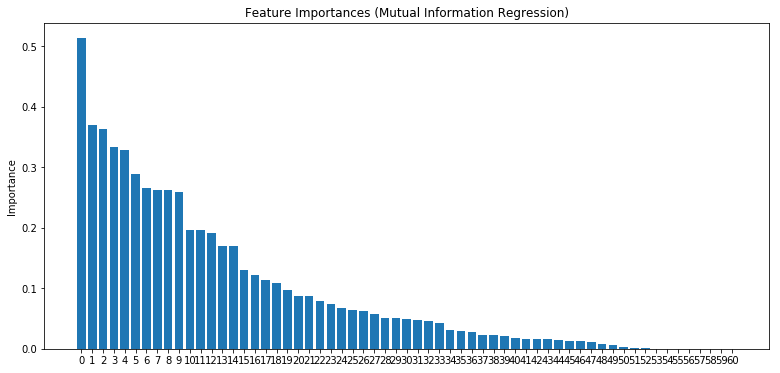

In [15]:
# and plot...
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
ind = np.arange(len(included_features))
plt.bar(ind,[float(i) for i in np.array(sorted_scores)[:,1]])
ax.axes.set_xticks(ind)
plt.title('Feature Importances (Mutual Information Regression)')
plt.ylabel('Importance')
# plt.xlabel('Trees in Forest')
# plt.grid()
plt.show()

**Step 4: Feature Pruning for Enhanced Model Performance**

Our current analysis indicates that a subset of features significantly impacts the performance of our random forest regressor model. To explore this further, we will systematically prune the feature set by selecting the top-ranking features. Specifically, we will consider the following feature counts: 15, 20, 30, 40, and 50.

Our approach ensures a rigorous assessment of feature importance, leading to an informed decision on feature inclusion. Once the models are built, we will visualize their comparative performance.

In [16]:
# define a function to do the necessary model building....
def getModel(sorted_scores,train,numFeatures):
    included_features = np.array(sorted_scores)[:,0][:numFeatures] # ordered list of important features
    # define the training data X...
    X = train[included_features]
    Y = train[['SalePrice']]
    # transform categorical data if included in X...
    for col in list(X):
        if X[col].dtype=='object':
            X = getObjectFeature(X, col)
    # define the number of estimators to consider
    estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
    mean_rfrs = []
    std_rfrs_upper = []
    std_rfrs_lower = []
    yt = [i for i in Y['SalePrice']]
    np.random.seed(11111)
    # for each number of estimators, fit the model and find the results for 8-fold cross validation
    for i in estimators:
        model = rfr(n_estimators=i,max_depth=None)
        scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
        mean_rfrs.append(scores_rfr.mean())
        std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
        std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting
    return mean_rfrs,std_rfrs_upper,std_rfrs_lower

# define a function to plot the model expected variance results...
def plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,numFeatures):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.plot(estimators,mean_rfrs,marker='o',
           linewidth=4,markersize=12)
    ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                    facecolor='green',alpha=0.3,interpolate=True)
    ax.set_ylim([-.2,1])
    ax.set_xlim([0,80])
    plt.title('Expected Variance of Random Forest Regressor: Top %d Features'%numFeatures)
    plt.ylabel('Expected Variance')
    plt.xlabel('Trees in Forest')
    plt.grid()
    plt.show()
    return

...and let's run the regression model fitting for each of the scenarios listed before...

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


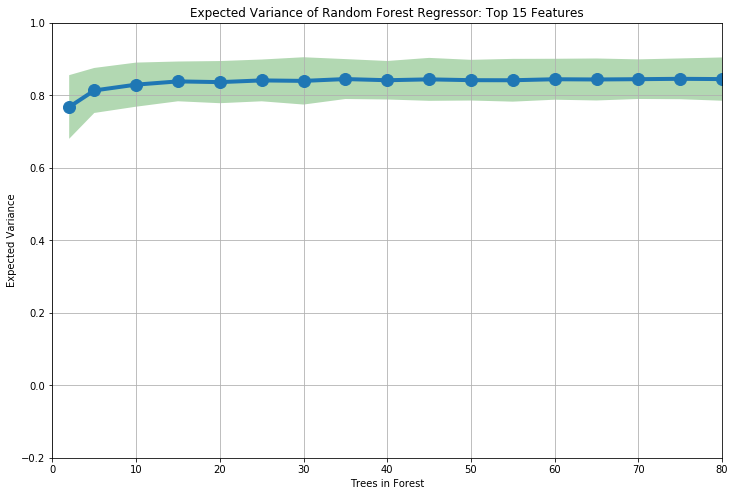

In [17]:
# top 15...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,15)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


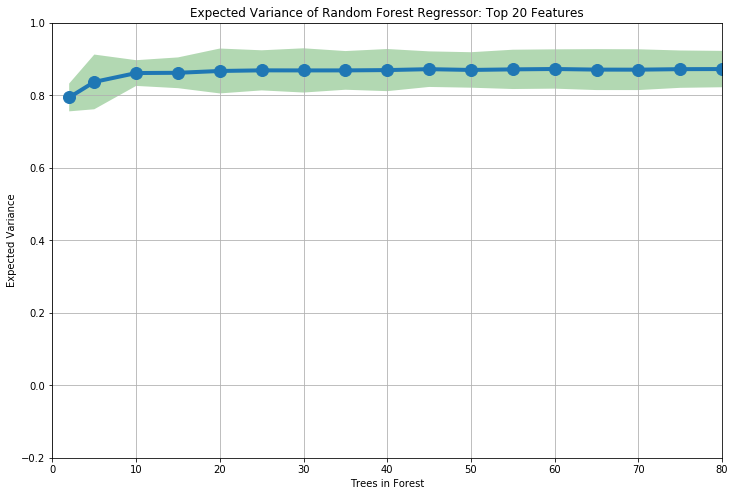

In [18]:
# top 20...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,20)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


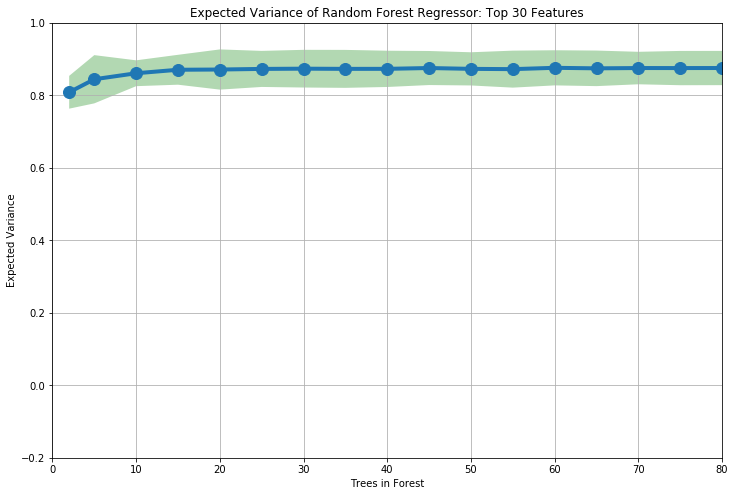

In [19]:
# top 30...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,30)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,30)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


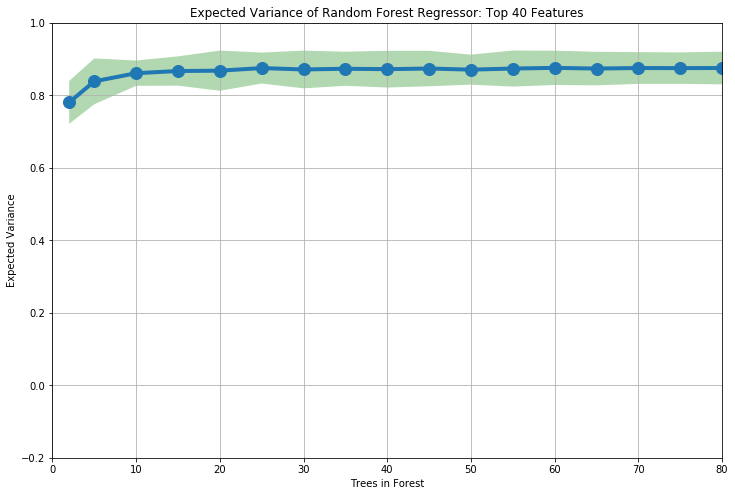

In [20]:
# top 40...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,40)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,40)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


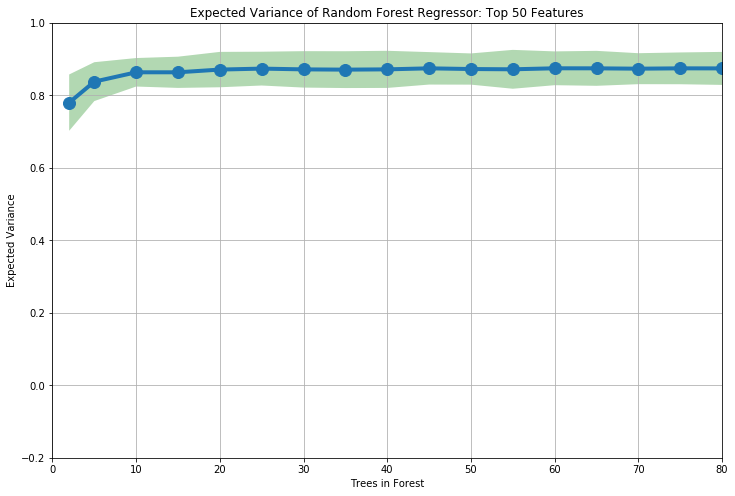

In [21]:
# top 50...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,50)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,50)

### Insights from Random Forest Regression Analysis

Our rigorous analysis of the random forest regression models reveals intriguing patterns. Here are the key findings:

1. **Feature Count and Model Performance**:
   - The mean expected variance of the regressions plateaus at approximately 20 features.
   - Optimal tree count in the forest ranges from 20 to 30, indicating diminishing returns beyond this range.
   - As expected, the deviation in the expected variance score decreases with an increasing number of features. This aligns with our intuition that more relevant features enhance model performance.

2. **Stability of 40-Feature and 50-Feature Models**:
   - Surprisingly, the results for 40 features and 50 features appear nearly identical.
   - This suggests that the 40th to 50th most important features contribute minimally to the overall predictive power.
   - Consequently, we recommend focusing solely on the top 40 features for subsequent analysis.

## Finalizing Model Output

Our journey culminates in constructing the output. Here are the key components of our best regression model:

1. **Random Forest Regression Model**:
   - We have meticulously crafted a robust random forest regression model.
   - This ensemble model leverages 60 regressor trees per forest, ensuring robustness and stability.
   - The model adheres to default settings for other parameters, maintaining consistency and reliability.

2. **Feature Selection**:
   - Our feature selection process involved identifying the 40 most influential features based on mutual information regression (MIR) analysis.
   - These features play a pivotal role in predicting the sales price.

3. **Test Data Application**:
   - We will now apply our optimized model to the test dataset.
   - The goal is to generate accurate predictions for the sales prices of residential properties.

With this comprehensive approach, we aim to deliver precise and reliable results. Let's proceed with applying the model and creating the final output.

In [22]:
# build the model with the desired parameters...
numFeatures = 40 # the number of features to inlcude
trees = 60 # trees in the forest
included_features = np.array(sorted_scores)[:,0][:numFeatures]
# define the training data X...
X = train[included_features]
Y = train[['SalePrice']]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
yt = [i for i in Y['SalePrice']]
np.random.seed(11111)
model = rfr(n_estimators=trees,max_depth=None)
scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
print('explained variance scores for k=10 fold validation:',scores_rfr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
# fit the model
model.fit(X,yt)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


explained variance scores for k=10 fold validation: [ 0.84300715  0.89703488  0.89517081  0.83918575  0.86654884  0.90095974
  0.88492673  0.90104156  0.85066814  0.86036962]
Est. explained variance: 0.87 (+/- 0.05)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [23]:
# let's read the test data to be sure...
test = pd.read_csv('../input/test.csv')

We will tweak the pre-processing function from before to handle missing data better, too...

In [24]:
# re-define a function to convert an object (categorical) feature into an int feature
# 0 = most common category, highest int = least common.
def getObjectFeature(df, col, datalength=1460):
    if df[col].dtype!='object': # if it's not categorical..
        print('feature',col,'is not an object feature.')
        return df
    else:
        df1 = df
        counts = df1[col].value_counts() # get the counts for each label for the feature
#         print(col,'labels, common to rare:',counts.index.tolist()) # get an ordered list of the labels
        df1[col] = [counts.index.tolist().index(i) 
                    if i in counts.index.tolist() 
                    else 0 
                    for i in df1[col] ] # do the conversion
        return df1 # make the new (integer) column from the conversion

In [25]:
# apply the model to the test data and get the output...
X_test = test[included_features]
for col in list(X_test):
    if X_test[col].dtype=='object':
        X_test = getObjectFeature(X_test, col, datalength=1459)
# print(X_test.head(20))
y_output = model.predict(X_test.fillna(0)) # get the results and fill nan's with 0
print(y_output)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[ 11.76616431  11.94897975  12.08819693 ...,  11.96282689  11.66081124
  12.35911794]


In [26]:
# transform the data to be sure
y_output = np.exp(y_output)
print(y_output)

[ 128819.09211963  154659.27440382  177761.30199441 ...,  156815.76003756
  115938.04625134  233075.55264608]


In [27]:
# define the data frame for the results
saleprice = pd.DataFrame(y_output, columns=['SalePrice'])
# print(saleprice.head())
# saleprice.tail()
results = pd.concat([test['Id'],saleprice['SalePrice']],axis=1)
results.head()

,Id,SalePrice
0,1461,128819.092120
1,1462,154659.274404
2,1463,177761.301994
3,1464,181290.564512
4,1465,192073.658970


In [28]:
# and write to output
results.to_csv('housepricing_submission.csv', index = False)